The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
Surface 10: 1.3*(11*exp(-3.3*(x-2.8)^4)+21*exp(-4.1*(x-0.13)^2)+16*exp(-4.3*(x+2.7)^2)-20*exp(-4.4*(x-3.4)^2)-28*exp(-3.4*(x+0.13)^4)-8*exp(-3.8*(x+3.5)^4)-10.0*exp(-1.2*(x+0.26)^6)-32*exp(-0.3*(x-3.2)^6)-38*exp(-0.304*(x+3.3)^6)+2*sin(-2*(x-1.1))^1)+exp(-x-4.5)^2+exp(x-4.5)^2


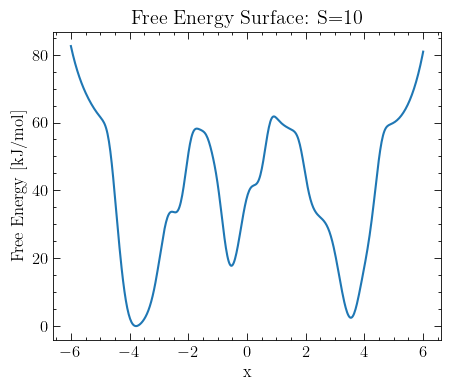

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
from scipy.interpolate import interp1d

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"



# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})

# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 50, 50, 50, 70, 60, 60, 70, 80, 80, 90, 80, 90, 80, 100, 100, 100, 110, 110]
    n_surf = 10
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=False)
    print(f"Surface {n_surf}: {y_string}")
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title(f"Free Energy Surface: S={n_surf}"); plt.show()

### Example simulation

In [2]:
path_notebook

'/home/ucecabj/Desktop/MFI_git/MFI_class1D'

In [3]:
# Stimulation path
path_simulation = path_notebook + "/_data_temp/"

# Select surface
n_surf = 10
y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]

# Set default parameters
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 2_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, "metad_width":0.1, "metad_height":5, "biasfactor":50 , 
                    "len_error_list":100, "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":True, "bootstrap_iter":50, 
                    "save_results":True, "save_mfi_instance":True, "simulation_folder_path": path_simulation, "print_info": True}

| 100% | AAD: 0.32 [kJ/mol] | Total time: 2 sec                                                            


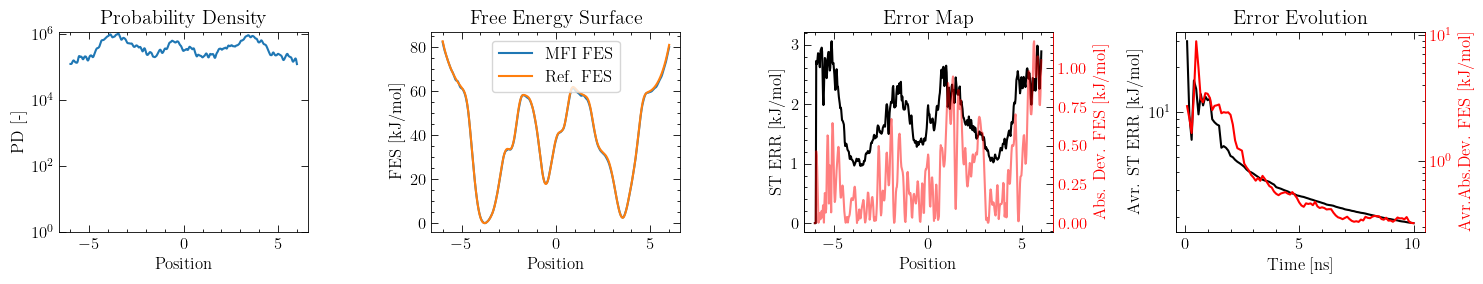

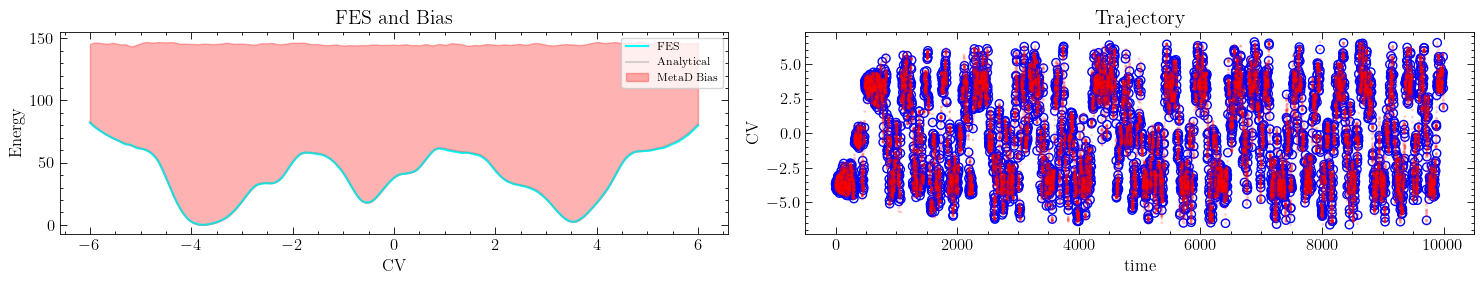

In [7]:
## Load MFI object
MFI = MFI_class1D.MFI1D(**default_params)

## Run the simulation
# MFI.run_simulation()

## Analyse the data
MFI.analyse_data()

## Plot the results and save the data for later use
MFI.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI.grid, fes=MFI.FES, metad_bias=MFI.Bias, position=MFI.position, hills=MFI.hills, y=MFI.y )

In [23]:
MFI.Avr_Error_info

['time', 'ratio_explored', 'Aofe', 'AAD', 'ABS_error', 'FES_st_dev']

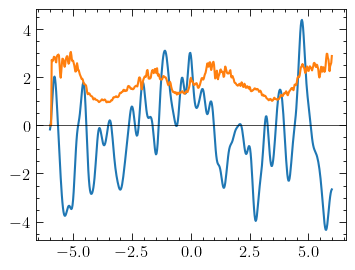

In [81]:
noise = np.random.normal(loc=0.0, scale=MFI.ofe)

correlation = 5
# kernel_size = int(6 * correlation)
# if kernel_size % 2 == 0:
#     kernel_size += 1
# kernel = gaussian_kernel(kernel_size, sigma=correlation)
# noise = np.convolve(noise, kernel, mode='same')
if correlation > 0: noise = gaussian_filter1d(noise, correlation) * correlation

plt.plot(MFI.grid, noise)
plt.plot(MFI.grid, MFI.ofe)
plt.axhline(0, color='black', lw=0.5)

In [86]:
def gaussian_kernel(kernel_size, sigma):

    x = np.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel / kernel.sum()

def propagate_error(force, error, dx, n_iterations=200, correlation=0.0):

    n_points = force.shape[0]
    perturbed_forces = np.empty((n_iterations, n_points))
    perturbed_fes = np.empty((n_iterations, n_points))
    
    for i in range(n_iterations):
        # Generate independent noise for each grid point
        noise = np.random.normal(loc=0.0, scale=error)
        
        if correlation > 0:
            # # Determine kernel size (using 6*sigma as a rule-of-thumb, ensuring it's odd)
            # kernel_size = int(6 * correlation)
            # if kernel_size % 2 == 0:
            #     kernel_size += 1
            # kernel = gaussian_kernel(kernel_size, sigma=correlation)
            # # Convolve the noise with the Gaussian kernel to introduce correlation.
            # noise = np.convolve(noise, kernel, mode='same')
            noise = gaussian_filter1d(noise, correlation)
        
        # Apply the noise to the original force.
        force_noise = force + noise
        # perturbed_forces[i, :] = force_noise
        # perturbed_fes[i, :] = lib1.FFT_intg_1D(force_noise, dx)
        perturbed_fes[i, :] = lib1.intg_1D(force + noise, dx)
        
    # Compute statistics across the iterations for each grid point.
    variance = np.var(perturbed_fes, axis=0)
    std = np.std(perturbed_fes, axis=0)
    std_error = std / np.sqrt(n_iterations)
    
    # return variance, std, std_error, np.mean(variance), np.mean(std), np.mean(std_error)
    return std, np.mean(std)


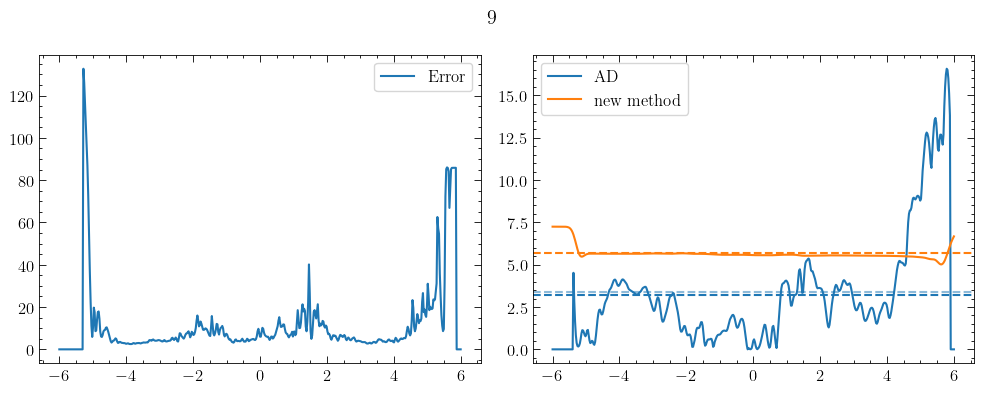

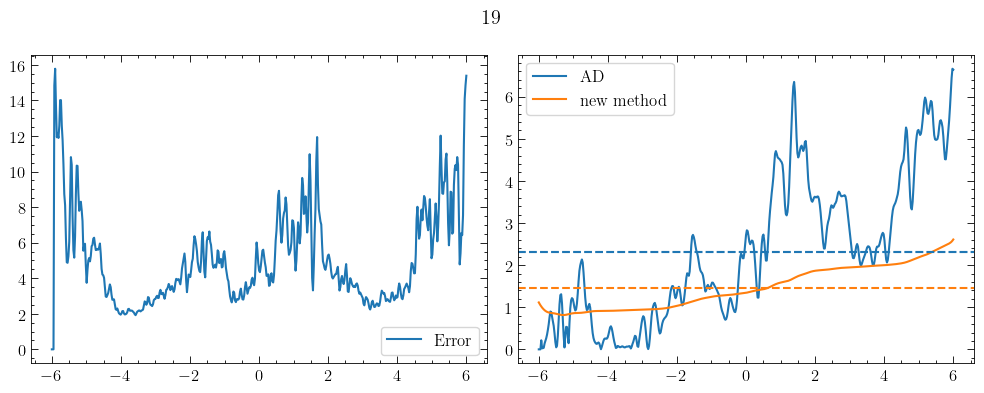

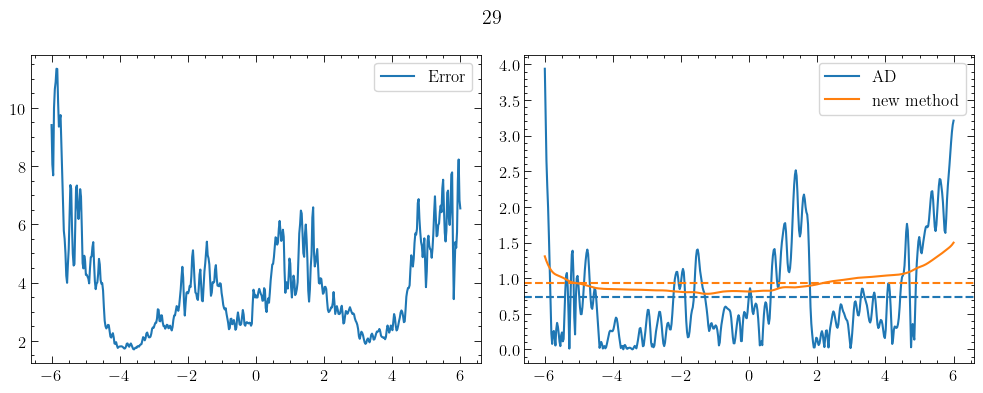

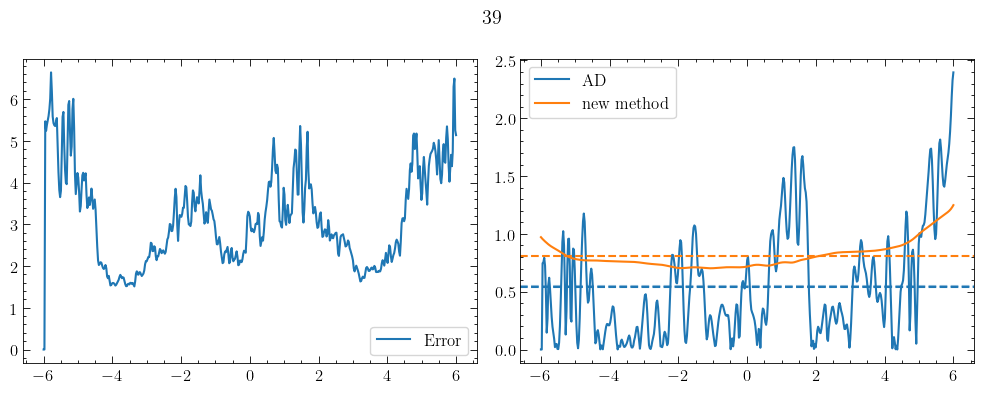

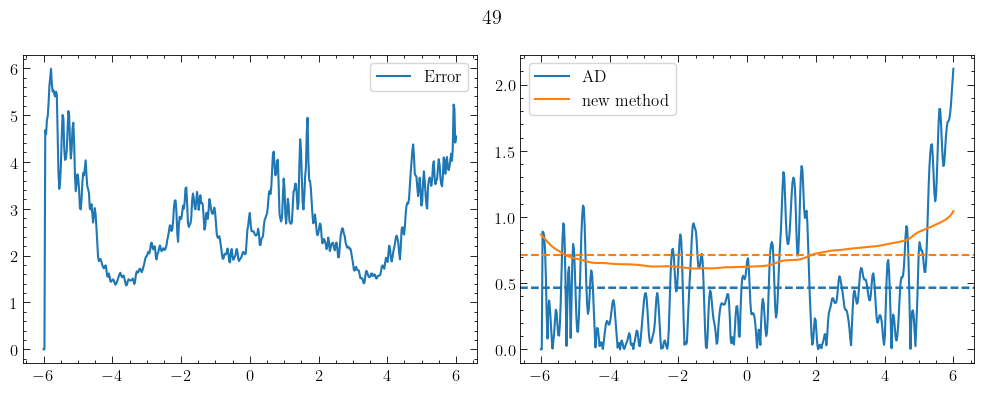

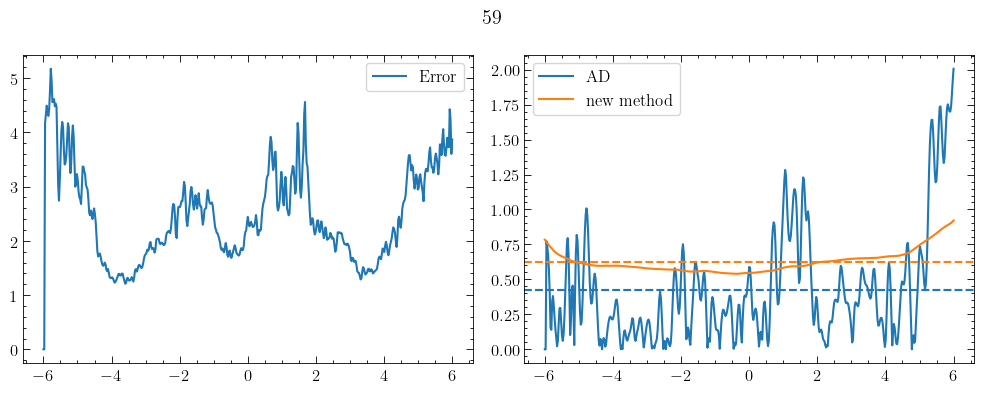

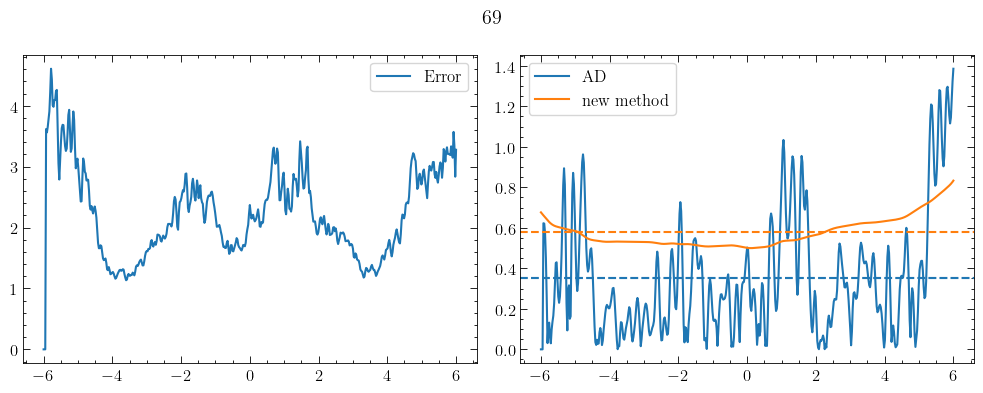

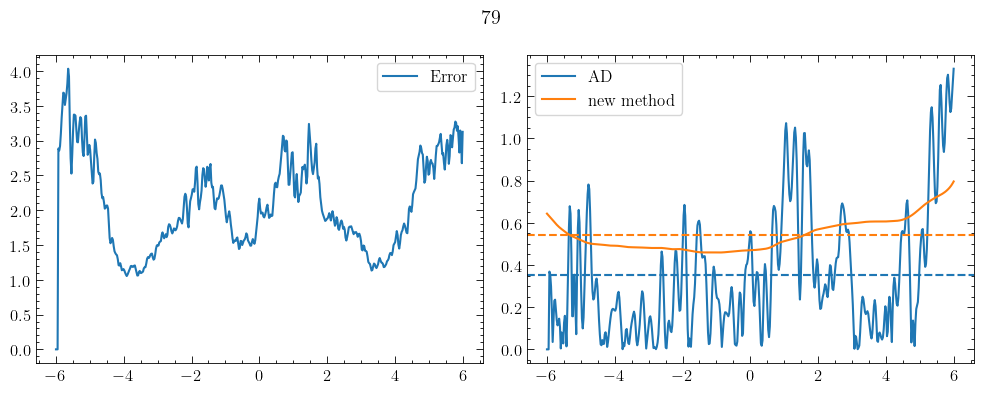

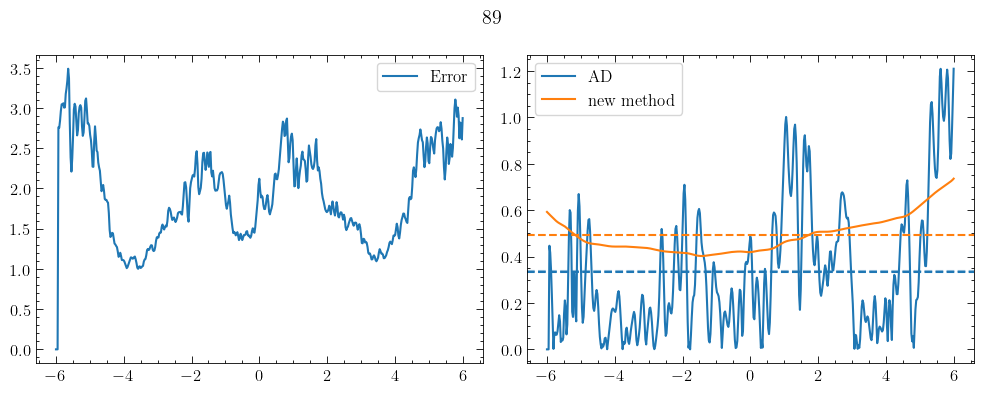

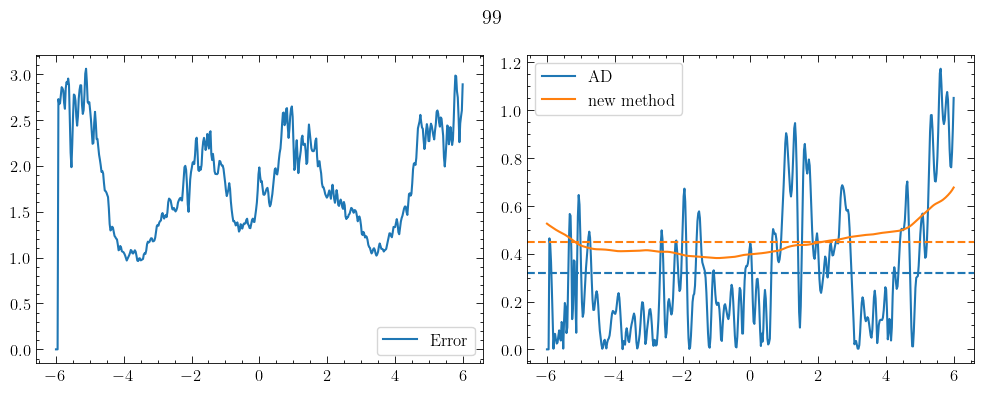

In [90]:
# import gaussian filter
from scipy.ndimage import gaussian_filter1d

for i in range(9, 100, 10):
    
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(MFI.grid, MFI.Maps_list[i, 2], label="Error")
    # error_smooth = gaussian_filter1d(MFI.Maps_list[i, 2], 5)
    # plt.plot(MFI.grid, error_smooth, label="Smoothed Error")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(MFI.grid, MFI.Maps_list[i, 3], label="AD")
    
    # error_fes = lib1.FFT_intg_1D(error_smooth, MFI.grid_dx)
    # plt.plot(MFI.grid, error_fes, label="FFT smooth")
    
    force = np.gradient(MFI.Maps_list[i, 3], MFI.grid_dx)
    
    err_fes, avr_err_fes = propagate_error(force, MFI.Maps_list[i, 2], dx=MFI.grid_dx, 
                                           n_iterations=1000, correlation=5)
    plt.plot(MFI.grid, err_fes, label="new method")

    plt.axhline(np.average(MFI.Maps_list[i, 3]), color="C0", linestyle="--")
    plt.axhline(MFI.Avr_Error_list[i, 3], color="C0", linestyle="--", alpha=0.5)
    plt.axhline(avr_err_fes, color="C1", linestyle="--")
    
    plt.legend()
    
    plt.suptitle(f" {i}"); plt.tight_layout();
    plt.show()
    

In [6]:
# list from 0 to 19
index_old = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19"]
index_new = ["0", "1", "OLD2", "2", "3", "OLD5", "7", "8", "5", "9", "10", "OLD11", "14", "11", "13", "16", "OLD16", "15", "18", "19"]
new_folder = ["4", "6", "12", "17"]




In [14]:
### rename data folders of surface X after changing surface list

# path_notebook

# path_folder = path_notebook + "/_data_SRTR/"

# for i, io in enumerate(index_old):
    
#     # change folder name from f"{path_folder}surf_{io}" to f"{path_folder}surf_{io}_temp"
#     os.rename(f"{path_folder}S{io}", f"{path_folder}S{io}_temp")
    
# for i, io in enumerate(index_old):

#     # change folder name from f"{path_folder}surf_{io}_temp" to f"{path_folder}surf_{index_new[i]}"
#     os.rename(f"{path_folder}S{io}_temp", f"{path_folder}S{index_new[i]}")
    
# for i_n in new_folder:
    
#     # make folder f"{path_folder}surf_{i_n}"
#     os.makedirs(f"{path_folder}S{i_n}")

In [36]:
# make list of numbers inceasing from 0.1 to 3 with 20 elements in total
results = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]#, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

print(len(results))

7


In [69]:
from math import ceil, sqrt
from matplotlib import colors

def plot_results_grid(results, results_min=None, results_max=None, n_rows=None, n_cols=None, title=None, row_label=None, col_label=None, row_ticks=None, col_ticks=None, cmap='RdYlGn_r', fig_size_scaling=1, ax=None, plot_show=True):
    """
    Plots a grid where each cell shows one element from results.
    
    Parameters:
      - results: list of numeric values (or "NA") to plot.
      - n_rows, n_cols: grid dimensions (if not provided, and if labels are available,
                        the grid size is taken from the length of the label lists;
                        otherwise, defaults are used).
      - row_ticks: list of strings for y-axis tick labels.
      - col_ticks: list of strings for x-axis tick labels.
      - cmap: colormap name to use for numeric values.
    """
    # Determine n_rows and n_cols
    if n_rows is None or n_cols is None:
        if row_ticks is not None and col_ticks is not None:
            n_rows, n_cols = len(row_ticks), len(col_ticks)
        else:
            n_cols = ceil(sqrt(len(results)))
            n_rows = ceil(len(results) / n_cols)
            
    total_cells = n_rows * n_cols
    # If there are too few results, pad with "NA"
    if len(results) < total_cells: results_extended = results + ["NA"] * (total_cells - len(results))
    else: results_extended = results[:total_cells]
    
    # Reshape the results list into a 2D grid (row-major order).
    grid = np.array(results_extended, dtype=object).reshape((n_rows, n_cols))
    
    # Set up the figure and axis.
    if ax is not None: plot_show = False
    if ax is None: fig, ax = plt.subplots(figsize=(n_cols*fig_size_scaling, n_rows*fig_size_scaling))
            
    # Prepare the colormap normalization using only numeric values.
    numeric_values = [val for val in results if isinstance(val, (int, float))]
    if results_min is not None: vmin = results_min
    elif numeric_values: vmin = min(numeric_values)
    else: vmin = 0
    
    if results_max is not None: vmax = results_max
    elif numeric_values: vmax = np.nanmax(numeric_values)
    else: vmax = 1

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap_obj = plt.get_cmap(cmap)
    
    # Draw each cell in the grid.
    for i in range(n_rows):
        for j in range(n_cols):
            val = grid[i, j]
            
            # Determine the display text and cell background color.            
            if isinstance(val, (int, float)): display_text, cell_color = f"{val:.3f}", cmap_obj(norm(val))
            elif val == "NA": display_text, cell_color = "NA", (0.9, 0.9, 0.9, 1.0)  # light gray for NA
            else: display_text, cell_color = str(val), (0.9, 0.9, 0.9, 1.0)
            
            # Draw the rectangle for the cell.
            rect = plt.Rectangle((j, i), 1, 1, facecolor=cell_color, edgecolor='black')
            ax.add_patch(rect)
            
            # Place the text in the center of the cell.
            ax.text(j + 0.5, i + 0.5, display_text, ha='center', va='center', color='black', fontweight='bold')
    
    
    # Set limits and ensure cells are square. Set ticks to be at the center of each cell.
    ax.set_xlim(0, n_cols); ax.set_ylim(0, n_rows); ax.set_aspect('equal')
    
    # invert y axis so that first values appear on the top row
    ax.invert_yaxis()
    
    ax.set_xticks(np.arange(n_cols) + 0.5); ax.set_yticks(np.arange(n_rows) + 0.5)
    
    # Apply tick labels if provided; otherwise, use default indices.
    if col_ticks is not None:
        tick_labels = col_ticks[:n_cols] if len(col_ticks) != n_cols else col_ticks
        ax.set_xticklabels(tick_labels, rotation=0, ha='center')
    else: ax.set_xticklabels([str(j) for j in range(n_cols)], rotation=0, ha='center')
    
    if row_ticks is not None:
        tick_labels = row_ticks[:n_rows] if len(row_ticks) != n_rows else row_ticks
        ax.set_yticklabels(tick_labels, rotation=0, va='center')
    else: ax.set_yticklabels([str(i) for i in range(n_rows)], rotation=0, va='center')
    
    # add labels and title
    if col_label is not None: ax.set_xlabel(col_label, labelpad=10)
    if row_label is not None: ax.set_ylabel(row_label, labelpad=10)
    if title is not None: ax.set_title(title)
    
    # Remove the axis spines and ticks for a cleaner look.
    ax.tick_params(top=False, bottom=False, left=False, right=False)
    for spine in ax.spines.values(): spine.set_visible(False)
    
    plt.tight_layout()
    if plot_show: plt.show()

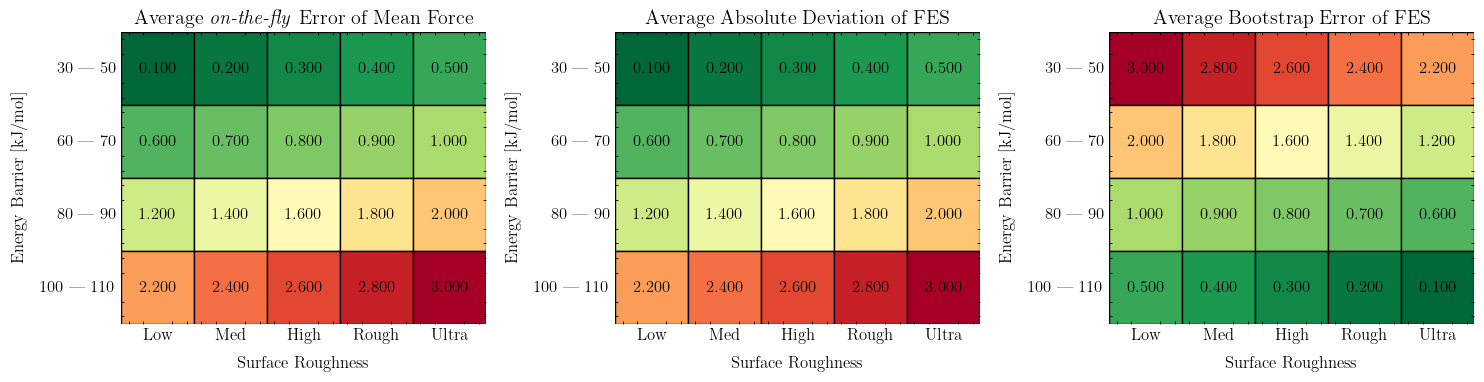

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

results = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

plot_results_grid(results, fig_size_scaling=1.2, ax=axes[0], title="Average \emph{on-the-fly} Error of Mean Force", 
                  row_label="Energy Barrier [kJ/mol]", col_label="Surface Roughness", row_ticks=["30 | 50", "60 | 70", "80 | 90", "100 | 110"], col_ticks=["Low", "Med", "High", "Rough", "Ultra"])


results = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]*2
plot_results_grid(results, fig_size_scaling=1.5, ax=axes[1], title="Average Absolute Deviation of FES", 
                  row_label="Energy Barrier [kJ/mol]", col_label="Surface Roughness", row_ticks=["30 | 50", "60 | 70", "80 | 90", "100 | 110"], col_ticks=["Low", "Med", "High", "Rough", "Ultra"])


results = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]*2
results = results[::-1]
plot_results_grid(results, fig_size_scaling=1.5, ax=axes[2], title="Average Bootstrap Error of FES", 
                  row_label="Energy Barrier [kJ/mol]", col_label="Surface Roughness", row_ticks=["30 | 50", "60 | 70", "80 | 90", "100 | 110"], col_ticks=["Low", "Med", "High", "Rough", "Ultra"])

plt.tight_layout(); plt.show()



### Block averaging test

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def generate_md_data(N=10000, alpha=0.95, sigma=1.0):
    data = np.zeros(N)
    for i in range(1, N): data[i] = alpha * data[i-1] + np.random.normal(0, sigma)
    return data

def compute_naive_stats(data):
    avg = np.mean(data)
    var = np.var(data, ddof=1)
    error = np.sqrt(var / len(data))
    return avg, error

def block_averaging_plateau(data, tol=0.05):
    """
    Compute the average and standard error of the mean using block averaging.
    The "right" block size is chosen by increasing the block size until the error estimate
    (obtained from the variance of the block averages) plateaus (i.e. changes less than tol).
    
    Returns:
        avg              - overall mean of the data
        error            - estimated standard error on the mean from block averaging
        chosen_block     - chosen block size based on plateau detection
        block_sizes      - list of block sizes tested
        error_estimates  - corresponding list of error estimates
    """
    N = len(data)
    block_sizes = []
    error_estimates = []
    
    # Use block sizes that are powers of 2 up to about N/4 (to keep enough blocks)
    b = 1
    while b <= N // 2:
        block_sizes.append(b)
        n_blocks = N // b
        # Only use full blocks:
        data_trunc = data[:n_blocks * b]
        blocks = data_trunc.reshape((n_blocks, b))
        block_means = np.mean(blocks, axis=1)
        # Standard error: sqrt(variance of block means divided by number of blocks)
        err = np.sqrt(np.var(block_means, ddof=1) / n_blocks)
        error_estimates.append(err)
        b += int(np.sqrt(b))

    # Find the first block size where the relative change in the error estimate is below tol
    chosen_block = block_sizes[-1]  # default: largest if no plateau found
    chosen_error = error_estimates[-1]
    for i in range(1, len(error_estimates)):
        rel_change = abs(error_estimates[i] - error_estimates[i-1]) / error_estimates[i-1]
        if rel_change < tol:
            chosen_block = block_sizes[i]
            chosen_error = error_estimates[i]
            break

    avg = np.mean(data)
    return avg, chosen_error, chosen_block, block_sizes, error_estimates

def autocorrelation(data, max_lag=None):
    """
    Compute the autocorrelation function (ACF) for the given data.
    
    Parameters:
        data    - 1D array of data
        max_lag - maximum lag (if None, defaults to half the data length)
    
    Returns:
        acf     - array of autocorrelation values for lags 0 to max_lag-1.
    """
    N = len(data)
    if max_lag is None:
        max_lag = N // 2
    data_mean = np.mean(data)
    # Use the population variance (ddof=0) for normalization.
    data_var = np.var(data, ddof=0)
    acf = np.empty(max_lag)
    for lag in range(max_lag):
        if lag == 0:
            acf[lag] = 1.0
        else:
            acf[lag] = np.sum((data[:-lag] - data_mean) * (data[lag:] - data_mean)) / ((N - lag) * data_var)
    return acf

def integrated_autocorrelation_time(acf):
    """
    Compute the integrated autocorrelation time (tau_int) from the autocorrelation function.
    tau_int = 1 + 2 * sum_{lag=1}^{lag_max} acf(lag)
    The summation stops when acf(lag) becomes negative.
    """
    tau = 1.0
    for lag in range(1, len(acf)):
        if acf[lag] < 0:
            break
        tau += 2 * acf[lag]
    return tau

def block_averaging_acf(data):
    """
    Compute the average and standard error of the mean using block averaging,
    where the block size is chosen based on the integrated autocorrelation time.
    
    The block size is set to ceil(tau_int), ensuring that each block is
    roughly as long as the time over which the data are correlated.
    
    Returns:
        avg         - overall mean of the data
        error       - estimated standard error on the mean from block averaging
        block_size  - block size used (from tau_int)
        tau_int     - integrated autocorrelation time
    """
    # Compute the autocorrelation function (limit max_lag to a reasonable value)
    acf = autocorrelation(data, max_lag=1000)
    tau_int = integrated_autocorrelation_time(acf)
    
    
    block_size = int(np.ceil(tau_int))
    if block_size < 1:
        block_size = 1
    N = len(data)
    n_blocks = N // block_size
    data_trunc = data[:n_blocks * block_size]
    blocks = data_trunc.reshape((n_blocks, block_size))
    block_means = np.mean(blocks, axis=1)
    error = np.sqrt(np.var(block_means, ddof=1) / n_blocks)
    avg = np.mean(data)
    return avg, error, block_size, tau_int



def find_block_size_acf(data, max_lag=None):
    """
    Determine an appropriate block size based on the autocorrelation function (ACF)
    computed via numpy's built-in functions.
    
    Parameters:
        data (array-like): The 1D time series data.
        max_lag (int, optional): The maximum lag at which to compute the ACF. 
                                 Defaults to half the length of the data.
    
    Returns:
        block_size (int): The suggested block size, chosen as ceil(integrated autocorrelation time).
        tau_int (float): The integrated autocorrelation time.
        acf_vals (ndarray): The autocorrelation values from lag 0 up to the lag where the ACF first becomes negative.
    """
    data = np.asarray(data)
    N = len(data)
    if max_lag is None: max_lag = N // 2

    # Subtract the mean to center the data
    x = data - np.mean(data)
    
    # Use np.correlate to compute the full autocorrelation. 
    # 'full' mode gives correlations at negative lags too. We take only non-negative lags.
    corr_full = np.correlate(x, x, mode='full')
    acf = corr_full[N-1:N+max_lag]
    acf = acf / acf[0]  # Normalize so that acf[0] == 1.

    # Calculate the integrated autocorrelation time.
    # The formula is: tau_int = 1 + 2 * sum_{lag=1}^{lag_max} acf(lag)
    # Here we stop summing when the ACF first becomes negative.
    tau_int = 1.0
    cutoff = len(acf)
    for lag in range(1, len(acf)):
        if acf[lag] < 0:
            cutoff = lag
            break
        tau_int += 2 * acf[lag]
    
    # The block size is chosen as the ceiling of the integrated autocorrelation time.
    block_size = int(np.ceil(tau_int))
    
    return block_size, tau_int, acf[:cutoff]

In [84]:
block_size, tau_int, acf_vals = find_block_size_acf(data)

print(block_size, "\n\n", tau_int, "\n\n", acf_vals)

40 

 39.051148227267895 

 [1.00000000e+00 9.48828405e-01 9.00469149e-01 8.55358751e-01
 8.12926196e-01 7.73648755e-01 7.36883318e-01 6.99901372e-01
 6.65598304e-01 6.34036001e-01 6.02159557e-01 5.73157359e-01
 5.47202858e-01 5.22525052e-01 4.99023690e-01 4.78420196e-01
 4.58428008e-01 4.38782374e-01 4.20012212e-01 3.99695421e-01
 3.78959676e-01 3.58975607e-01 3.39341780e-01 3.20166182e-01
 3.02745242e-01 2.86082301e-01 2.71018109e-01 2.56745603e-01
 2.43681038e-01 2.30911293e-01 2.17853051e-01 2.06717894e-01
 1.96565676e-01 1.86290567e-01 1.75721358e-01 1.66820966e-01
 1.59192805e-01 1.51886217e-01 1.44478699e-01 1.37855877e-01
 1.31560750e-01 1.25371447e-01 1.18009554e-01 1.11670679e-01
 1.04522528e-01 9.79125806e-02 9.09770851e-02 8.55175646e-02
 7.98552754e-02 7.44166040e-02 6.80294946e-02 6.29552970e-02
 5.93029495e-02 5.63447952e-02 5.51170023e-02 5.32527821e-02
 5.18821893e-02 4.88475222e-02 4.55992332e-02 4.24884829e-02
 3.93280436e-02 3.66517587e-02 3.47132562e-02 3.16512897e

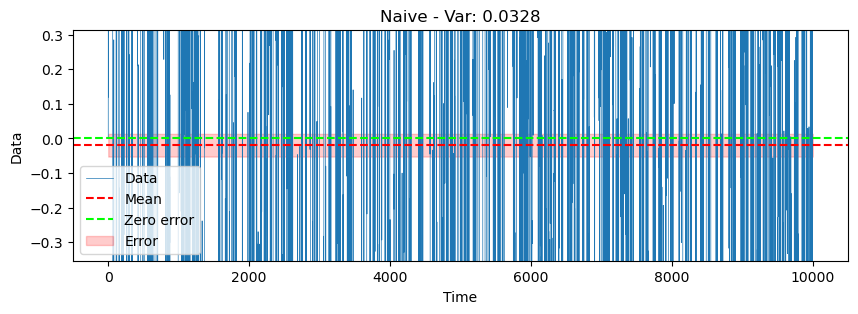

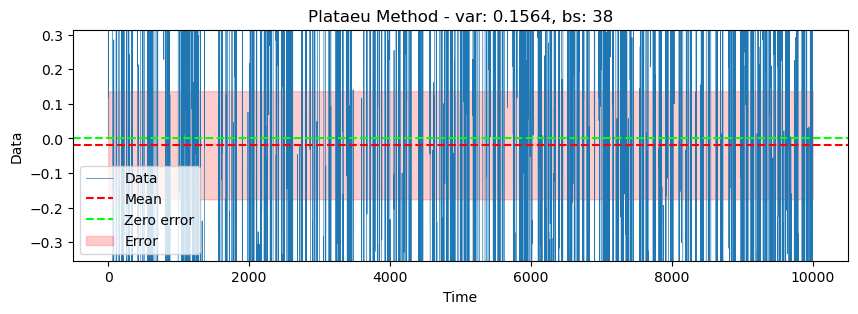

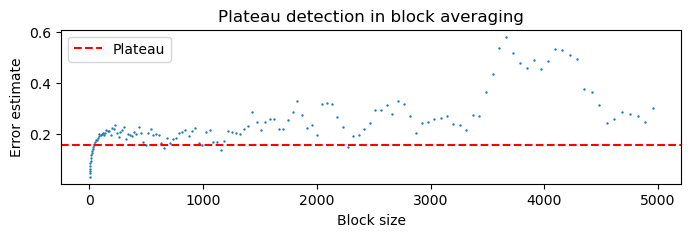

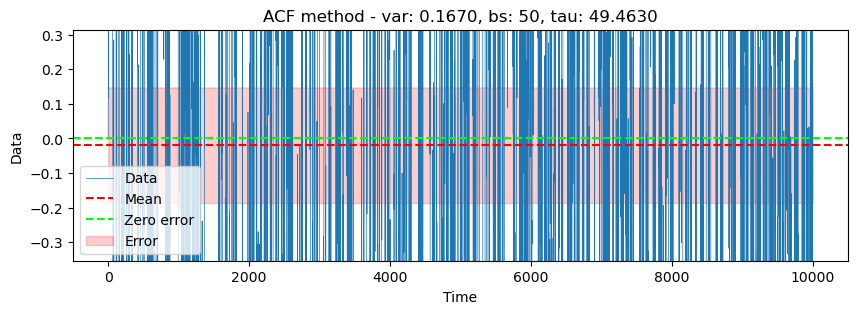

50 49.31911893761261


In [85]:
# Generate dummy correlated MD data
data = generate_md_data(N=10000, alpha=0.95, sigma=1.0)

# 1. Naive statistics (ignoring correlations)
avg_naive, error_naive = compute_naive_stats(data)

# 2. Block averaging with plateau method
avg_plateau, error_plateau, chosen_block, block_sizes, error_estimates = block_averaging_plateau(data, tol=0.05)

# 3. Block averaging using autocorrelation function
avg_acf, error_acf, block_size_acf, tau_int = block_averaging_acf(data)

y_min = min(avg_naive - 2*error_naive, avg_plateau - 2*error_plateau, avg_acf - 2*error_acf, -0.1)
y_max = max(avg_naive + 2*error_naive, avg_plateau + 2*error_plateau, avg_acf + 2*error_acf, 0.1)

plt.figure(figsize=(10, 3));
plt.plot(range(len(data)), data, linewidth=0.5, label="Data")
plt.axhline(avg_naive, color='red', linestyle='--', label="Mean")
plt.axhline(0, color='lime', linestyle='--', label="Zero error")
plt.fill_between(range(len(data)), avg_naive - error_naive, avg_naive + error_naive, color='red', alpha=0.2, label="Error"); 
plt.legend(); plt.ylim(y_min, y_max)
plt.xlabel("Time"); plt.ylabel("Data"); plt.title(f"Naive - Var: {error_naive:.4f}"); plt.show()

plt.figure(figsize=(10, 3));
plt.plot(range(len(data)), data, linewidth=0.5, label="Data")
plt.axhline(avg_plateau, color='red', linestyle='--', label="Mean")
plt.axhline(0, color='lime', linestyle='--', label="Zero error")
plt.fill_between(range(len(data)), avg_plateau - error_plateau, avg_plateau + error_plateau, color='red', alpha=0.2, label="Error"); 
plt.legend(); plt.ylim(y_min, y_max)
plt.xlabel("Time"); plt.ylabel("Data"); plt.title(f"Plataeu Method - var: {error_plateau:.4f}, bs: {chosen_block}"); plt.show()

# plot block_sizes vs. error_estimates to visualize the plateau.
plt.figure(figsize=(8, 2))
plt.scatter(block_sizes, error_estimates, s=0.5)
plt.axhline(error_plateau, color='red', linestyle='--', label="Plateau")
plt.xlabel("Block size"); plt.ylabel("Error estimate"); plt.title("Plateau detection in block averaging")
plt.legend(); plt.show()

plt.figure(figsize=(10, 3));
plt.plot(range(len(data)), data, linewidth=0.5, label="Data")
plt.axhline(avg_acf, color='red', linestyle='--', label="Mean")
plt.axhline(0, color='lime', linestyle='--', label="Zero error")
plt.fill_between(range(len(data)), avg_acf - error_acf, avg_acf + error_acf, color='red', alpha=0.2, label="Error"); 
plt.legend(); plt.ylim(y_min, y_max)
plt.xlabel("Time"); plt.ylabel("Data"); plt.title(f"ACF method - var: {error_acf:.4f}, bs: {block_size_acf}, tau: {tau_int:.4f}"); plt.show()

block_size, tau_int, acf_vals = find_block_size_acf(data)
print(block_size, tau_int)

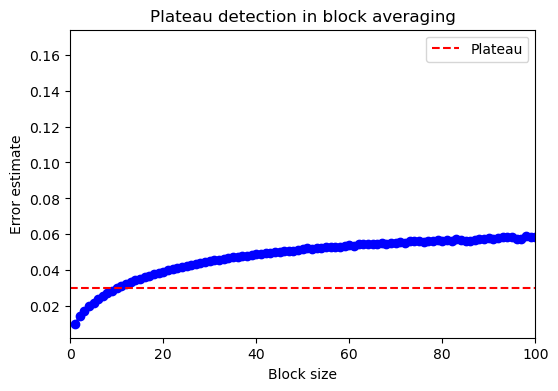

In [65]:
plt.figure(figsize=(6, 4))
plt.plot(block_sizes, error_estimates, marker='o', linestyle='-', color='blue')
plt.axhline(error_plateau, color='red', linestyle='--', label="Plateau")
plt.xlabel("Block size"); plt.ylabel("Error estimate"); plt.title("Plateau detection in block averaging")

plt.xlim(0, 100)

plt.legend(); plt.show()

